In [2]:
# General utilities
import os
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from dotenv import load_dotenv
import glob

# NetCDF / data handling
import xarray as xr

# Plotting
import matplotlib.pyplot as plt

# Copernicus Marine Toolbox
from copernicusmarine import login, subset

# Time series modeling
from statsmodels.tsa.arima.model import ARIMA

# OpenDrift simulation
from opendrift.models.oceandrift import OceanDrift
from opendrift.readers.reader_netCDF_CF_generic import Reader

/home/diana-bacircea/miniconda3/envs/opendrift/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
load_dotenv()

# Fetch credentials
username = os.getenv("CMDS_USERNAME")
password = os.getenv("CMDS_PASSWORD")

if not username or not password:
    raise ValueError("CMDS_USERNAME or CMDS_PASSWORD not set in .env")

# Authenticate with Copernicus Marine
login(username=username, password=password)

File /home/diana-bacircea/.copernicusmarine/.copernicusmarine-credentials already exists, overwrite it ? [y/N]:

In [ ]:
def download_cmems(year, output_dir,
                   min_lon=160, max_lon=180, min_lat=-77, max_lat=-72,
                   start_depth=0, end_depth=1):
    import os
    from datetime import datetime
    from copernicusmarine import subset
    import xarray as xr

    os.makedirs(output_dir, exist_ok=True)
    output_file = f"copernicus_currents_{year}.nc"
    output_path = os.path.join(output_dir, output_file)

    if os.path.exists(output_path):
        print(f"✅ Already exists: {output_path}")
        return

    # Dataset selection
    if year <= 2020:
        dataset_id = "cmems_mod_glo_phy_my_0.083deg_P1D-m"
    else:
        dataset_id = "cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m"
    variables = ['uo', 'vo']

    if year == 2025:
        # Special case: only download January 2025
        try:
            print(f"⬇️ Downloading January {year} only...")
            subset(
                dataset_id=dataset_id,
                minimum_longitude=min_lon,
                maximum_longitude=max_lon,
                minimum_latitude=min_lat,
                maximum_latitude=max_lat,
                minimum_depth=start_depth,
                maximum_depth=end_depth,
                start_datetime=f"{year}-01-01 00:00:00",
                end_datetime=f"{year}-01-31 23:59:59",
                variables=variables,
                output_directory=output_dir,
                output_filename=output_file,
                netcdf3_compatible=True
            )
            print(f"✅ Saved: {output_path}")
        except Exception as e:
            print(f"❌ Failed for January 2025: {e}")
        return

    # Normal case: download both December and January
    dec_file = os.path.join(output_dir, f"tmp_{year}_dec.nc")
    jan_file = os.path.join(output_dir, f"tmp_{year}_jan.nc")

    success_dec = False
    success_jan = False

    try:
        print(f"⬇️ Downloading December {year}...")
        subset(
            dataset_id=dataset_id,
            minimum_longitude=min_lon,
            maximum_longitude=max_lon,
            minimum_latitude=min_lat,
            maximum_latitude=max_lat,
            minimum_depth=start_depth,
            maximum_depth=end_depth,
            start_datetime=f"{year}-12-01 00:00:00",
            end_datetime=f"{year}-12-31 23:59:59",
            variables=variables,
            output_directory=output_dir,
            output_filename=os.path.basename(dec_file),
            netcdf3_compatible=True
        )
        success_dec = os.path.exists(dec_file)
    except Exception as e:
        print(f"⚠️ December {year} failed: {e}")

    try:
        print(f"⬇️ Downloading January {year + 1}...")
        subset(
            dataset_id=dataset_id,
            minimum_longitude=min_lon,
            maximum_longitude=max_lon,
            minimum_latitude=min_lat,
            maximum_latitude=max_lat,
            minimum_depth=start_depth,
            maximum_depth=end_depth,
            start_datetime=f"{year + 1}-01-01 00:00:00",
            end_datetime=f"{year + 1}-01-31 23:59:59",
            variables=variables,
            output_directory=output_dir,
            output_filename=os.path.basename(jan_file),
            netcdf3_compatible=True
        )
        success_jan = os.path.exists(jan_file)
    except Exception as e:
        print(f"⚠️ January {year + 1} failed: {e}")

    if success_dec and success_jan:
        try:
            ds_dec = xr.open_dataset(dec_file)
            ds_jan = xr.open_dataset(jan_file)
            ds_combined = xr.concat([ds_dec, ds_jan], dim="time")
            ds_combined.to_netcdf(output_path)
            print(f"✅ Saved: {output_path}")
        except Exception as e:
            print(f"❌ Failed to merge/save for {year}: {e}")
    else:
        print(f"⚠️ Skipping save for {year}: missing one of the months")

    # Cleanup
    for f in [dec_file, jan_file]:
        if os.path.exists(f):
            os.remove(f)


In [ ]:
for year in range(2013, 2026):
    download_cmems(year, output_dir="data")


✅ Already exists: data/copernicus_currents_2013.nc
✅ Already exists: data/copernicus_currents_2014.nc
✅ Already exists: data/copernicus_currents_2015.nc
✅ Already exists: data/copernicus_currents_2016.nc
✅ Already exists: data/copernicus_currents_2017.nc
✅ Already exists: data/copernicus_currents_2018.nc
✅ Already exists: data/copernicus_currents_2019.nc
✅ Already exists: data/copernicus_currents_2020.nc
⬇️ Downloading December 2021...


INFO - 2025-07-10T21:56:28Z - Selected dataset version: "202406"
21:56:28 INFO    copernicusmarine:369: Selected dataset version: "202406"
INFO - 2025-07-10T21:56:28Z - Selected dataset part: "default"
21:56:28 INFO    copernicusmarine:397: Selected dataset part: "default"


⚠️ December 2021 failed: Some of your subset selection [2021-12-01 00:00:00+00:00, 2021-12-31 23:59:59+00:00] for the time dimension exceed the dataset coordinates [2022-06-01 00:00:00+00:00, 2025-07-19 00:00:00+00:00]
⬇️ Downloading January 2022...


INFO - 2025-07-10T21:56:30Z - Selected dataset version: "202406"
21:56:30 INFO    copernicusmarine:369: Selected dataset version: "202406"
INFO - 2025-07-10T21:56:30Z - Selected dataset part: "default"
21:56:30 INFO    copernicusmarine:397: Selected dataset part: "default"


⚠️ January 2022 failed: Some of your subset selection [2022-01-01 00:00:00+00:00, 2022-01-31 23:59:59+00:00] for the time dimension exceed the dataset coordinates [2022-06-01 00:00:00+00:00, 2025-07-19 00:00:00+00:00]
⚠️ Skipping save for 2021: missing one of the months
⬇️ Downloading December 2022...


INFO - 2025-07-10T21:56:32Z - Selected dataset version: "202406"
21:56:32 INFO    copernicusmarine:369: Selected dataset version: "202406"
INFO - 2025-07-10T21:56:32Z - Selected dataset part: "default"
21:56:32 INFO    copernicusmarine:397: Selected dataset part: "default"
WARNING - 2025-07-10T21:56:33Z - Some of your subset selection [0, 1] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
21:56:33 WARNING copernicusmarine:833: Some of your subset selection [0, 1] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
INFO - 2025-07-10T21:56:34Z - Starting download. Please wait...
21:56:34 INFO    copernicusmarine:213: Starting download. Please wait...
100%|██████████| 18/18 [00:09<00:00,  2.00it/s]
INFO - 2025-07-10T21:56:43Z - Successfully downloaded to data/tmp_2022_dec.nc
21:56:43 INFO    copernicusmarine:229: Successfully downloaded to data/tmp_2022_dec.nc


⬇️ Downloading January 2023...


INFO - 2025-07-10T21:56:44Z - Selected dataset version: "202406"
21:56:44 INFO    copernicusmarine:369: Selected dataset version: "202406"
INFO - 2025-07-10T21:56:44Z - Selected dataset part: "default"
21:56:44 INFO    copernicusmarine:397: Selected dataset part: "default"
WARNING - 2025-07-10T21:56:45Z - Some of your subset selection [0, 1] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
21:56:45 WARNING copernicusmarine:833: Some of your subset selection [0, 1] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
INFO - 2025-07-10T21:56:46Z - Starting download. Please wait...
21:56:46 INFO    copernicusmarine:213: Starting download. Please wait...
100%|██████████| 18/18 [00:07<00:00,  2.31it/s]
INFO - 2025-07-10T21:56:54Z - Successfully downloaded to data/tmp_2022_jan.nc
21:56:54 INFO    copernicusmarine:229: Successfully downloaded to data/tmp_2022_jan.nc


✅ Saved: data/copernicus_currents_2022.nc
✅ Already exists: data/copernicus_currents_2023.nc
✅ Already exists: data/copernicus_currents_2024.nc
⬇️ Downloading January 2025 only...


INFO - 2025-07-10T21:56:55Z - Selected dataset version: "202406"
21:56:55 INFO    copernicusmarine:369: Selected dataset version: "202406"
INFO - 2025-07-10T21:56:55Z - Selected dataset part: "default"
21:56:55 INFO    copernicusmarine:397: Selected dataset part: "default"
WARNING - 2025-07-10T21:56:57Z - Some of your subset selection [0, 1] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
21:56:57 WARNING copernicusmarine:833: Some of your subset selection [0, 1] for the depth dimension exceed the dataset coordinates [0.49402499198913574, 5727.9169921875]
INFO - 2025-07-10T21:56:58Z - Starting download. Please wait...
21:56:58 INFO    copernicusmarine:213: Starting download. Please wait...
100%|██████████| 18/18 [00:09<00:00,  1.88it/s]
INFO - 2025-07-10T21:57:07Z - Successfully downloaded to data/copernicus_currents_2025.nc
21:57:07 INFO    copernicusmarine:229: Successfully downloaded to data/copernicus_currents_2025.nc


✅ Saved: data/copernicus_currents_2025.nc


In [ ]:
dj_uo_series = {}
dj_vo_series = {}
lat = None
lon = None

for year in range(2013, 2025):  # up to 2024 inclusive
    file_dec = f"data/copernicus_currents_{year}.nc"
    file_jan = f"data/copernicus_currents_{year + 1}.nc"

    if not (os.path.exists(file_dec) and os.path.exists(file_jan)):
        print(f"⚠️ Skipping year {year}: missing Dec or Jan file.")
        continue

    try:
        ds_dec = xr.open_dataset(file_dec)
        ds_dec = ds_dec.where(ds_dec['time'].dt.month == 12, drop=True)

        ds_jan = xr.open_dataset(file_jan)
        ds_jan = ds_jan.where(ds_jan['time'].dt.month == 1, drop=True)

        ds_dj = xr.concat([ds_dec, ds_jan], dim="time")
    except Exception as e:
        print(f"⚠️ Failed to open/filter DJ data for {year}: {e}")
        continue

    if lat is None:
        lat = ds_dj.latitude.values
        lon = ds_dj.longitude.values

    for i in range(len(lat)):
        for j in range(len(lon)):
            try:
                key = (i, j)
                u_vals = ds_dj['uo'][:, i, j].values
                v_vals = ds_dj['vo'][:, i, j].values

                if np.isnan(u_vals).all() or np.isnan(v_vals).all():
                    continue

                dj_uo_series.setdefault(key, []).append(np.nanmean(u_vals))
                dj_vo_series.setdefault(key, []).append(np.nanmean(v_vals))
            except Exception:
                continue


⚠️ Skipping year 2020: missing Dec or Jan file.
⚠️ Skipping year 2021: missing Dec or Jan file.


In [ ]:
# Load December 2024 and January 2025 actual Copernicus data
reader_dec = Reader('data/copernicus_currents_2024.nc')
reader_jan = Reader('data/copernicus_currents_2025.nc')

# Initialize OceanDrift model
o = OceanDrift(loglevel=20)
o.add_reader([reader_dec, reader_jan])  # add both readers

# Nurdle properties
nurdle_diameter = 0.0035  # meters
nurdle_density = 980      # kg/m^3
total_mass = 740000       # kg

particle_volume = (4/3) * np.pi * (nurdle_diameter/2)**3
particle_mass = nurdle_density * particle_volume
simulated_particles = 2000

print(f"Simulating {simulated_particles} particles with total mass {total_mass} kg")

# Seed region around central Ross Sea
seed_lons = np.random.uniform(169.5, 170.5, simulated_particles)
seed_lats = np.random.uniform(-75.5, -74.5, simulated_particles)

# Seed particles on December 1, 2024
o.seed_elements(
    lon=seed_lons,
    lat=seed_lats,
    time=datetime(2024, 12, 1),
)

# Run simulation through January 2025
o.run(end_time=datetime(2025, 1, 31), time_step=3600, time_step_output=86400)


22:08:38 INFO    opendrift.readers:61: Opening file with xr.open_dataset
22:08:38 INFO    opendrift.readers.reader_netCDF_CF_generic:299: Grid coordinates are detected, but proj4 string not given: assuming latlong
22:08:38 INFO    opendrift.readers.reader_netCDF_CF_generic:332: Detected dimensions: {'z': 'depth', 'y': 'latitude', 'time': 'time', 'x': 'longitude'}
22:08:38 INFO    opendrift.readers.basereader:176: Variable x_sea_water_velocity will be rotated from eastward_sea_water_velocity
22:08:38 INFO    opendrift.readers.basereader:176: Variable y_sea_water_velocity will be rotated from northward_sea_water_velocity
22:08:38 INFO    opendrift.readers:61: Opening file with xr.open_dataset
22:08:38 INFO    opendrift.readers.reader_netCDF_CF_generic:299: Grid coordinates are detected, but proj4 string not given: assuming latlong
22:08:38 INFO    opendrift.readers.reader_netCDF_CF_generic:332: Detected dimensions: {'z': 'depth', 'y': 'latitude', 'time': 'time', 'x': 'longitude'}
22:08:3

Simulating 2000 particles with total mass 740000 kg


22:08:38 INFO    opendrift:2015: 2024-12-02 09:00:00 - step 34 of 1464 - 2000 active elements (0 deactivated)
22:08:38 INFO    opendrift:2015: 2024-12-02 10:00:00 - step 35 of 1464 - 2000 active elements (0 deactivated)
22:08:38 INFO    opendrift:2015: 2024-12-02 11:00:00 - step 36 of 1464 - 2000 active elements (0 deactivated)
22:08:38 INFO    opendrift:2015: 2024-12-02 12:00:00 - step 37 of 1464 - 2000 active elements (0 deactivated)
22:08:38 INFO    opendrift:2015: 2024-12-02 13:00:00 - step 38 of 1464 - 2000 active elements (0 deactivated)
22:08:38 INFO    opendrift:2015: 2024-12-02 14:00:00 - step 39 of 1464 - 2000 active elements (0 deactivated)
22:08:38 INFO    opendrift:2015: 2024-12-02 15:00:00 - step 40 of 1464 - 2000 active elements (0 deactivated)
22:08:38 INFO    opendrift:2015: 2024-12-02 16:00:00 - step 41 of 1464 - 2000 active elements (0 deactivated)
22:08:38 INFO    opendrift:2015: 2024-12-02 17:00:00 - step 42 of 1464 - 2000 active elements (0 deactivated)
22:08:38 I

<xarray.Dataset> Size: 10MB
Dimensions:                                   (trajectory: 2000, time: 62)
Coordinates:
  * trajectory                                (trajectory) int64 16kB 0 ... 1999
  * time                                      (time) datetime64[ns] 496B 2024...
Data variables: (12/21)
    status                                    (trajectory, time) float32 496kB ...
    moving                                    (trajectory, time) float32 496kB ...
    age_seconds                               (trajectory, time) float32 496kB ...
    origin_marker                             (trajectory, time) float32 496kB ...
    lon                                       (trajectory, time) float32 496kB ...
    lat                                       (trajectory, time) float32 496kB ...
    ...                                        ...
    upward_sea_water_velocity                 (trajectory, time) float32 496kB ...
    sea_surface_wave_significant_height       (trajectory, time) float32 496kB ...
    sea_surface_wave_stokes_drift_x_velocity  (trajectory, time) float32 496kB ...
    sea_surface_wave_stokes_drift_y_velocity  (trajectory, time) float32 496kB ...
    sea_floor_depth_below_sea_level           (trajectory, time) float32 496kB ...
    land_binary_mask                          (trajectory, time) float32 496kB ...
Attributes: (12/117)
    Conventions:                                                           CF...
    standard_name_vocabulary:                                              CF...
    featureType:                                                           tr...
    title:                                                                 Op...
    summary:                                                               Ou...
    keywords:                                                              tr...
    ...                                                                    ...
    geospatial_lon_units:                                                  de...
    geospatial_lon_resolution:                                             point
    runtime:                                                               0:...
    geospatial_vertical_min:                                               0.0
    geospatial_vertical_max:                                               0.0
    geospatial_vertical_positive:                                          up

22:08:55 WARNING opendrift:2371: Plotting fast. This will make your plots less accurate.


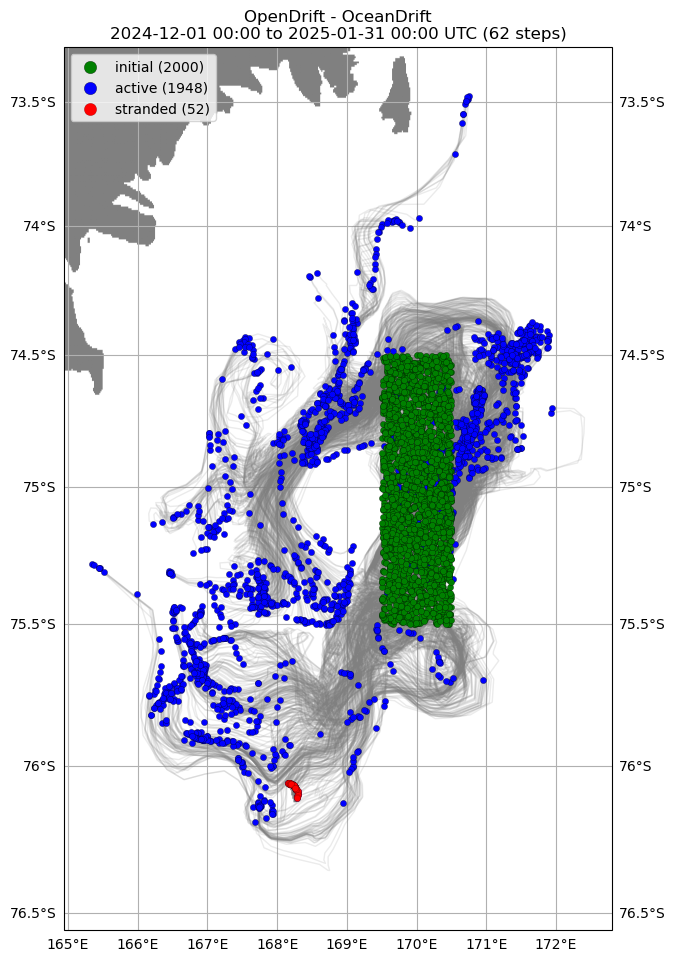

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2024-12-01 00:00 to 2025-01-31 00:00 UTC (62 steps)'}>,
 <Figure size 686.019x1100 with 1 Axes>)

In [ ]:
o.plot(fast=True, legend=True, filename=None)

In [ ]:
o.animation(
    filename="nurdle_dispersion_dec_2024_jan_2025.mp4",
    show_elements=True,
    show_trajectory=True,
    marker_size=2,
    dpi=150,
    fast=True,
    show_time=True,
    show_legend=True
)

22:09:07 WARNING opendrift:2371: Plotting fast. This will make your plots less accurate.
22:09:07 INFO    opendrift:4533: Saving animation to nurdle_dispersion.mp4...
22:09:24 INFO    opendrift:2974: Time to make animation: 0:00:17.002689


## WORK IN PROGRESS BELOW!!!

### ARIMA model for December-January currents

In [8]:
# Load and combine all available NetCDF files from 2013–2025
data_dir = "data"
all_files = sorted(glob.glob(os.path.join(data_dir, "copernicus_currents_*.nc")))
ds_list = [xr.open_dataset(f) for f in all_files if os.path.exists(f)]
combined = xr.concat(ds_list, dim="time")
uo, vo = combined["uo"], combined["vo"]

# Forecast shape: (62, lat, lon)
forecast_days = 62
lat_len, lon_len = uo.shape[1], uo.shape[2]
forecast_arima_dec_2025_jan_2026 = {"uo": np.zeros((forecast_days, lat_len, lon_len)),
                                    "vo": np.zeros((forecast_days, lat_len, lon_len))}

def arima_forecast_3d(component):
    result = np.full((forecast_days, lat_len, lon_len), np.nan)
    for i in range(lat_len):
        for j in range(lon_len):
            series = component[:, i, j].values
            if np.any(np.isnan(series)):
                continue
            try:
                model = ARIMA(series, order=(1, 0, 0)).fit()
                forecast = model.forecast(steps=forecast_days)
                result[:, i, j] = forecast
            except:
                continue
    return result

forecast_arima_dec_2025_jan_2026["uo"] = arima_forecast_3d(uo)
forecast_arima_dec_2025_jan_2026["vo"] = arima_forecast_3d(vo)

time = pd.date_range("2025-12-01", periods=62)
lat = np.linspace(-75, -70, forecast_arima_dec_2025_jan_2026["uo"].shape[1])
lon = np.linspace(160, 170, forecast_arima_dec_2025_jan_2026["uo"].shape[2])

# Save ARIMA forecast
ds_arima = xr.Dataset(
    {
        "uo": (["time", "lat", "lon"], forecast_arima_dec_2025_jan_2026["uo"]),
        "vo": (["time", "lat", "lon"], forecast_arima_dec_2025_jan_2026["vo"]),
    },
    coords={"time": time, "lat": lat, "lon": lon}
)
ds_arima.to_netcdf("data/forecast_arima_dec_2025_jan_2026.nc")



In [9]:
# Load December 2024 and January 2025 actual Copernicus data
reader = Reader('data/forecast_arima_dec_2025_jan_2026.nc')

# Initialize OceanDrift model
o = OceanDrift(loglevel=20)
o.add_reader([reader_dec, reader_jan])  # add both readers

# Nurdle properties
nurdle_diameter = 0.0035  # meters
nurdle_density = 980      # kg/m^3
total_mass = 740000       # kg

particle_volume = (4/3) * np.pi * (nurdle_diameter/2)**3
particle_mass = nurdle_density * particle_volume
simulated_particles = 2000

print(f"Simulating {simulated_particles} particles with total mass {total_mass} kg")

# Seed region around central Ross Sea
seed_lons = np.random.uniform(169.5, 170.5, simulated_particles)
seed_lats = np.random.uniform(-75.5, -74.5, simulated_particles)

# Seed particles on December 1, 2025
o.seed_elements(
    lon=seed_lons,
    lat=seed_lats,
    time=datetime(2025, 12, 1),
)

# Run simulation through January 2026
o.run(end_time=datetime(2026, 1, 31), time_step=3600, time_step_output=86400)


IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
print(reader)

Reader: data/forecasted_currents_2025_12_to_2026_01.nc
Projection: 
  +proj=latlong
Coverage: [degrees]
  xmin: 160.000000   xmax: 180.000000   step: 0.0833282   numx: 241
  ymin: -77.000000   ymax: -72.000000   step: 0.0833359   numy: 60
  Corners (lon, lat):
    (160.00, -72.00)  (180.00, -72.00)
    (160.00, -77.00)  (180.00, -77.00)
Vertical levels [m]: 
  Not specified
Available time range:
  start: 2025-12-01 00:00:00   end: 2026-01-31 00:00:00   step: 1 day, 0:00:00
    62 times (0 missing)
Variables:



22:39:43 WARNING opendrift:2371: Plotting fast. This will make your plots less accurate.


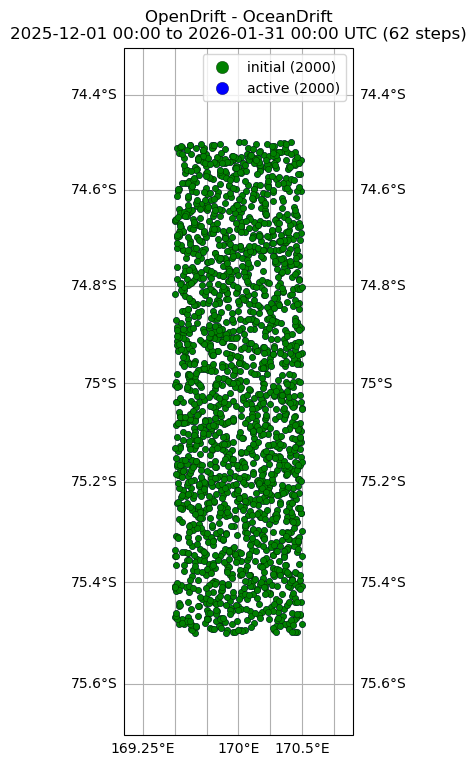

(<GeoAxes: title={'center': 'OpenDrift - OceanDrift\n2025-12-01 00:00 to 2026-01-31 00:00 UTC (62 steps)'}>,
 <Figure size 365.957x1100 with 1 Axes>)

In [ ]:
o.plot(fast=True, legend=True, filename=None)